Creating a Sentence Tokenizer on the version 9 of the corpora
----------------------------------

The process is almost the same as in [processing_4](text_processing4.ipynb) excepted that we will create another custom dataset for the custom transformer model and identify with a box plot the range of the maximum length of the sequences in order to tune the `max_len` parameter provided to the custom dataset.

Let us import the necessary libraries.

In [34]:
# # for creating the tokenizer
from tokenizers import (
    decoders,
#     SentencePieceBPETokenizer,
#     normalizers,
#     pre_tokenizers,
)
# from transformers import AutoTokenizer, PreTrainedTokenizerFast, T5TokenizerFast

import sentencepiece as spm

# for importing and manipulating the sentences
import pandas as pd
import random

# for plotting the box plot of the sequence lengths
import plotly.express as px

# for loading sentences with the custom dataset
from torch.utils.data import DataLoader

#### Load dataset and create generator

We will create one tokenizer for both of the French and Wolof corpora because the `T5` model understand only one embedding layer. So we must create one generator for both of the French and Wolof corpora. 

In [35]:
# load sentences
sentences = pd.read_csv("data/extractions/new_data/corpora_v9.csv")

# initialize a batch size
BATCH_SIZE = 400

# create generators (for the corpora)
# def generate_sents():
    
#     # recuperate the sentences
#     french_sents = sentences['french'].to_list() 
    
#     wolof_sents = sentences['wolof'].to_list() 
    
#     sents = french_sents + wolof_sents
    
#     for i in range(1, len(sents), BATCH_SIZE):
        
#         yield sents[i:i+BATCH_SIZE]

with open('sents.txt', 'w', encoding='utf-8') as f:
    for sent in sentences['french'].to_list() + sentences['wolof'].to_list():
        f.write(sent + '\n')

#### Initialize the tokenizer

In [36]:
# tokenizer = Tokenizer(models.Unigram())

#### Add normalizer

In [37]:
# tokenizer.normalizer = normalizers.Replace(" {2,}", " ")

#### Initialize the trainers

We will provide all of the necessary special tokens to the T5 Tokenizer (see [t5_tokenizer](_t5.ipynb)). 

In [38]:
special_tokens = ['<pad>', '</s>', '<unk>']

In [39]:
# trainer = trainers.UnigramTrainer(special_tokens=special_tokens, unk_token = "<unk>", vocab_size=20000) # let us take the default vocab size

#### Train the tokenizer

The SentencePiece tokenizer automatically performs a normalization (the `NFKC` Unicode). 

In [40]:
spm.SentencePieceTrainer.Train(input = f'sents.txt',
                               model_prefix='wolof-translate/wolof_translate/tokenizers/t5_tokenizers/tokenizer_v8',
                               vocab_size=15000,
                               character_coverage=1.0,
                               pad_id=0,                
                               eos_id=1,
                               unk_id=2,
                               bos_id=3,
                               pad_piece='<pad>',
                               eos_piece='</s>',
                               unk_piece='<unk>',
                               bos_piece='<s>',
                               )

Load the tokenizer.

In [41]:
tokenizer = spm.SentencePieceProcessor(model_file='wolof-translate/wolof_translate/tokenizers/t5_tokenizers/tokenizer_v8.model')

#### Make a little example

Let us recuperate random sentences from the corpora and tokenize them.

In [42]:
random.seed(200)

french_sentence = random.choice(sentences['french']) 

wolof_sentence = random.choice(sentences['wolof']) 


In [43]:
# print the french sentence
french_sentence

"Mais à la fin de l'été 1968, encerclée, décimée par les troupes fédérales sous le commandement du général Benjamin Adekunle, surnommé pour sa cruauté le « Scorpion noir », l'armée biafraise capitule."

In [44]:
# print the wolof sentence
wolof_sentence

'Mu nga toog ca taatu aloom ga.'

In [45]:
french_encoding = tokenizer.Encode(french_sentence, add_eos=True)

print("French tokens")
print([tokenizer.IdToPiece(id) for id in french_encoding])

print("French ids")
print(french_encoding)

French tokens
['▁Mais', '▁à', '▁la', '▁fin', '▁de', '▁l', "'", 'été', '▁1968', ',', '▁encerclé', 'e', ',', '▁déc', 'imé', 'e', '▁par', '▁les', '▁troupe', 's', '▁fédérale', 's', '▁sous', '▁le', '▁commande', 'ment', '▁du', '▁général', '▁Ben', 'jam', 'in', '▁Adekunle', ',', '▁sur', 'nommé', '▁pour', '▁sa', '▁cru', 'auté', '▁le', '▁', '«', '▁S', 'corpion', '▁noir', '▁»', ',', '▁l', "'", 'armée', '▁biafrais', 'e', '▁capit', 'ule', '.', '</s>']
French ids
[531, 22, 7, 606, 8, 15, 6, 3647, 5304, 5, 7233, 18, 5, 13040, 12542, 18, 100, 28, 10416, 11, 11478, 11, 431, 17, 7910, 222, 38, 5161, 1095, 4681, 567, 4291, 5, 88, 13592, 60, 56, 2765, 5845, 17, 9, 220, 187, 13990, 918, 266, 5, 15, 6, 1541, 4300, 18, 8525, 3038, 4, 1]


In [46]:
wolof_encoding = tokenizer.Encode(wolof_sentence, add_eos=True)

print("Wolof tokens")
print([tokenizer.IdToPiece(id) for id in wolof_encoding])

print("Wolof ids")
print(wolof_encoding)

Wolof tokens
['▁Mu', '▁nga', '▁toog', '▁ca', '▁taat', 'u', '▁aloom', '▁ga', '.', '</s>']
Wolof ids
[136, 55, 404, 82, 1755, 44, 5420, 219, 4, 1]


#### Creating the T5 custom dataset for the new sentences

We have two possibilities to use the tokenizer for fine-tuning a T5 model. 

- We can use the `PreTrainedTokenizerFast` class for which we will provide the different special tokens.

In [47]:
# from transformers import PreTrainedTokenizerFast

# wrapped_tokenizer1 = PreTrainedTokenizerFast(
#     tokenizer_object=tokenizer,
#     bos_token="<s>",
#     eos_token="</s>",
#     unk_token="<unk>",
#     pad_token="<pad>",
#     cls_token="<cls>",
#     sep_token="<sep>",
#     mask_token="<mask>",
#     padding_side="left",
# )

- Or give directly the tokenizer to the `T5TokenizerFast` class.

In [48]:
from transformers import T5TokenizerFast

wrapped_tokenizer1 = T5TokenizerFast(
    vocab_file='wolof-translate/wolof_translate/tokenizers/t5_tokenizers/tokenizer_v8.model'
)


Let us give them the sentences that we use as example. 

In [49]:
wf_encoding = wrapped_tokenizer1(french_sentence, max_length=40, padding='max_length', truncation=True)

wf_encoding

{'input_ids': [531, 22, 7, 606, 8, 15, 6, 3647, 5304, 5, 7233, 18, 5, 13040, 12542, 18, 100, 28, 10416, 11, 11478, 11, 431, 17, 7910, 222, 38, 5161, 1095, 4681, 567, 4291, 5, 88, 13592, 60, 56, 2765, 5845, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [50]:
wf_encoding = wrapped_tokenizer1(wolof_sentence, max_length=40, padding='max_length', truncation=True)

wf_encoding

{'input_ids': [136, 55, 404, 82, 1755, 44, 5420, 219, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

Let us decode the wolof sentence.

In [51]:
wrapped_tokenizer1.decode(wf_encoding.input_ids, skip_special_tokens=True)

'Mu nga toog ca taatu aloom ga.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

We can see that the `T5Tokenizer` add padding to the right side of the sequence while the `PretrainedTokenizer` add the padding to the left side. We can change the padding side from the settings. But, for the next steps, let us directly use the `T5Tokenizer`.

**Note that we can augment the sentences when generating them like we did when using the `GPT2 model`.** See the following notebook, [augmentation](text_augmentation.ipynb), for discussion on the augmentation method that we will use. And for a more clear explanation of the augmentation methods in NLP tasks and training, look at the following article from the web [augment_or_not](https://direct.mit.edu/coli/article/48/1/5/108844/To-Augment-or-Not-to-Augment-A-Comparative-Study).

Let us verify, before creating the custom dataset, the max length that we can get from the corpora' tokens without considering the augmentation. We must for that trace the box plot of the lengths and identify the range in which we will sample the max length (the max length is the highest length comparing that of the input sentence and that of the target sentence) of the sequences.

In [52]:
length = []

for i in range(sentences['french'].shape[0]):
    
    sent1 = sentences['french'][i]
    
    sent2 = sentences['wolof'][i]
    
    len_ids = max(len(wrapped_tokenizer1(sent1).input_ids), len(wrapped_tokenizer1(sent2).input_ids))
    
    length.append(len_ids)

        

In [53]:
# trace the histogram of the length with a appropriate template and labels with indian red color with displayed counts
fig = px.histogram(length, template="plotly_white", labels=dict(x="Length of the sentences", y="Number of sentences"), color_discrete_sequence=['indianred'], marginal="box", nbins=100, text_auto=True)

# change name of the variable
fig.update_traces(name="Length of the sentences")


fig.show()

The upper fence is of **29** and the max length is equal to **268**. 

----------------

We can also use a buckets by lengths. For that we can take as first boundary the upper fence and then determine another limits. Let us take for that dataset the following boundaries got with the histogram:

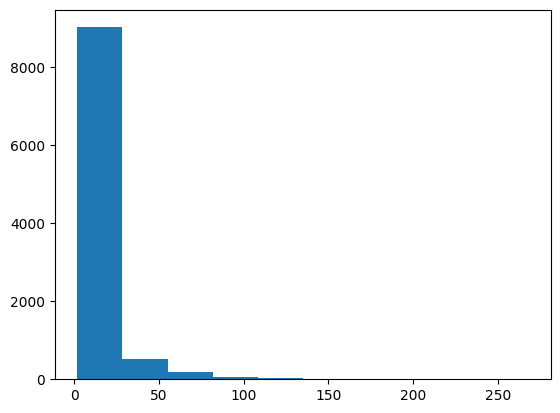

In [54]:
import numpy as np
from math import ceil
import matplotlib.pyplot as plt

# Create histogram
hist, bins, _ = plt.hist(length, bins=10)  # Adjust the number of bins as needed

# Analyze the histogram
# Identify peaks or gaps to determine the boundaries

# Choose the boundaries based on the analysis
boundaries = [ceil(bins[0])] + [ceil(bin) for bin, count in zip(bins[1:], hist) if count > 10] + [np.inf]

In [55]:
bins

array([  2. ,  28.6,  55.2,  81.8, 108.4, 135. , 161.6, 188.2, 214.8,
       241.4, 268. ])

In [56]:
hist

array([9.019e+03, 5.160e+02, 1.820e+02, 6.500e+01, 3.100e+01, 1.500e+01,
       5.000e+00, 4.000e+00, 3.000e+00, 3.000e+00])

We trace 10 bins and if the number of sequences in a bin is higher than 10 we take the length as a boundary:

In [57]:
boundaries

[2, 29, 56, 82, 109, 135, 162, inf]

In [58]:
%run wolof-translate/wolof_translate/data/dataset_v4.py

Let us generate some data with their masks and decode the labels.

**Note that we will use, when training the `T5 model`, train and test sets and not directly the full dataset**

In [59]:
# t5_tokenizer = T5TokenizerFast.from_pretrained("t5-small")

# wrapped_tokenizer1.eos_token_id = t5_tokenizer.eos_token_id

# wrapped_tokenizer1.pad_token_id = t5_tokenizer.pad_token_id

# wrapped_tokenizer1.unk_token_id = t5_tokenizer.unk_token_id

In [60]:
# Initialize our custom dataset
dataset = SentenceDataset("data/extractions/new_data/corpora_v9.csv", wrapped_tokenizer1, truncation=True, max_len = 15)

In [61]:
generator = torch.manual_seed(5)
input_ids, input_mask, labels, _ = next(iter(DataLoader(dataset, 10, shuffle=True, generator=generator))) # generate 10 sentences with shuffling

Let us print the input ids.

In [62]:
input_ids

tensor([[   91,     6, 13621, 10234,   273,    36,  1261,    68,  1577,     4,
             1,     0,     0,     0,     0,     0,     0,     0],
        [   91,     6,  3597,    23,  2013,    27,    17,  1278,     4,     1,
             0,     0,     0,     0,     0,     0,     0,     0],
        [   74,   764,    86,    29,  1244,     4,     1,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [ 3710,  8316,    86,   860,    41,     6,    50,    29,   300,     8,
          1929,     5,   538,    15,     6, 12722,  2101,     1],
        [  141,  7557,    18,    31,  1543,   291,    26,    18,  1914,     5,
            47,    79,   759,     8,     7,   835,    60,     1],
        [   74,  1383,   519,    47,    29,    99,    29,    26,    18,   908,
             8,  2117,     4,     1,     0,     0,     0,     0],
        [ 1445,  4977,    10,   111,   248,  1148,    41,     6,  1249,    29,
          3191,    21,     1,     0,     0,     0, 

In [63]:
input_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [64]:
labels

tensor([[ 3964,   707,    55,   721,    18,    82,  1652,  3948,   388,   626,
           219,     4,     1,     0,     0,     0,     0,     0],
        [ 7532,    34,    38,  1209,    18,   591,   312,     4,     1,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [12682,    34,    51,  2568,    33,     4,     1,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [ 2465,  1477,    37,   582,  1286,  1722,    10,  6480,   525,    82,
           897,     5,    45,  1003,   108,  8428,  3759,     1],
        [  230,  4779,  2767,     5,  2767,  1601,   856,    82,     4,     1,
             0,     0,     0,     0,     0,     0,     0,     0],
        [ 4047,    51,    70,    19,  1751,     5,     8,  1500,  4469,     7,
             4,     1,     0,     0,     0,     0,     0,     0],
        [ 1392,   919,   645,  8268,    10, 13379,    23,   148,   578,  3892,
             7,    21,     1,     0,     0,     0, 

Let us decode the labels.

In [65]:
dataset.decode(labels)

['Tëgg gaa nga bañe ca mbànjaxaan ga.',
 'Gumba du jiite aw yoon.',
 'Laafa gi wadd na.',
 'Fekkkoon mu jóge Móris juróomi-ñetti at ca ginnaaw, ba ňu fa dàqee njabootam',
 'Lu cin xat, xat xorom xaj ca.',
 'Der gi ñu ko liggéeye, deru mbëtt la.',
 'Xanaa danga réere-mbir ne Omar géwël la?',
 'Fiñ ko tëj moom kenn, mu ngi yuuxu, di xataraayu bay bëgg',
 'Salliiñ si lañuy tabaxe fii.',
 'Mu ngi may cat-bëtu.']